# <img style="float: left; padding: 0px 10px 0px 0px;" src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/84/Escudo_de_la_Pontificia_Universidad_Cat%C3%B3lica_de_Chile.svg/1920px-Escudo_de_la_Pontificia_Universidad_Cat%C3%B3lica_de_Chile.svg.png"  width="80" /> MCD3100 - Ciencia de Datos Geoespaciales
**Pontificia Universidad Católica de Chile**<br>
**Magister en Ciencia de Datos**<br>

# Tutorial 2: Datos vectoriales I.


Este tutorial tiene como objetivos:
- Realizar calculos geométricos simples.
- Construir nuevas geometrías mediantes buffers y uniones.
- Realizar operaciones de superposición y unión espacial de capas vectoriales.
- Elaborar gráficos de coropletas.


In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import shapely
import contextily as ctx

## 2. Datos.

Para este tutorial utilizaremos los datos exportados en el Tutorial N°1:
- `vm_comuna.gpkg`
- `vm_vial.gpkg`
- `vm_manz.gpkg`

Puedes usar los mismos datos que generaste en el Tutorial 1, o usar los adjuntos a este tutorial.

Agregaremos además los datos de población del Censo 2017 (ya que los resultados de población por manzana censal del Censo 2024 aún no están disponibles):

- `vm_censo2017.gpkg`

Y también, una capa disponible en la IDE Chile con la geometría de la [línea litoral de Chile](https://www.geoportal.cl/geoportal/catalog/35650/L%C3%ADnea%20Litoral):`LneaLitoral.shp`








## 3. Ejercicios.

En este tutorial, buscaremos respondar a la siguientes preguntas:
- ¿Cuál es la superficie y largo total de calles de Viña del Mar?
- ¿Qué manzanas de la comuna están ubicadas a menos de 500 m de la línea de playa? Este es un dato relevante por ejemplo para identificar ubicaciones de interés para propiedades en arriendo, o para analizar la correlación entre precios de propiedades y cercanía a la playa.
- ¿Cuántas personas viven a menos de 500 m de la línea de playa? Este es un dato relevante por ejemplo para la planificación de medidas de evacuación en caso de tsunami.

### 3.1 Lectura e inspección de datos vectoriales.

In [2]:
vina=gpd.read_file('data_T2/vm_comuna.gpkg')
vial=gpd.read_file('data_T2/vm_vial.gpkg')
manz=gpd.read_file('data_T2/vm_manz.gpkg')
censo=gpd.read_file('data_T2/vm_censo2017.gpkg')

In [3]:
vina.crs

<Geographic 2D CRS: EPSG:4674>
Name: SIRGAS 2000
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Latin America - Central America and South America - onshore and offshore. Brazil - onshore and offshore.
- bounds: (-122.19, -59.87, -25.28, 32.72)
Datum: Sistema de Referencia Geocentrico para las AmericaS 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [4]:
litoral=gpd.read_file('data_T2/Costa/LneaLitoral.shp')
litoral.crs

<Geographic 2D CRS: GEOGCS["SIRGAS-Chile",DATUM["SIRGAS-Chile_realizat ...>
Name: SIRGAS-Chile
Axis Info [ellipsoidal]:
- lon[east]: Longitude (Degree)
- lat[north]: Latitude (Degree)
Area of Use:
- undefined
Datum: SIRGAS-Chile realization 1 epoch 2002
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

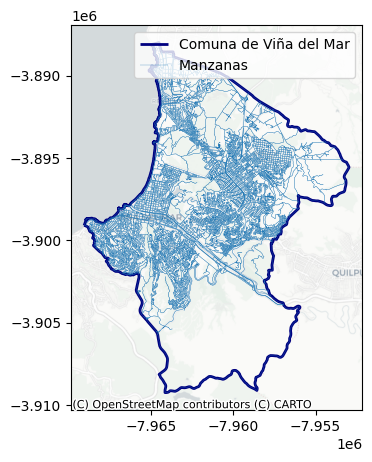

In [15]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)

crs='3857'

vina.to_crs(crs).boundary.plot(ax=ax,color='navy',lw=2,label='Comuna de Viña del Mar')
#vial.to_crs(crs).plot(ax=ax,color='k',lw=0.5,label='Ejes viales')
manz.to_crs(crs).boundary.plot(ax=ax,lw=0.2,label='Manzanas')
#manz.to_crs(crs).plot(ax=ax,lw=0.2,label='Manzanas')
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.legend()
plt.show()

### 3.2 ¿Cuál es la superficie de Viña del Mar?

In [7]:
vina.area  #en grados sexagesimales

C:\Users\Erick\AppData\Local\Temp\ipykernel_28344\874077330.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  vina.area  #en grados sexagesimales


0    0.011631
dtype: float64

In [8]:
vina.to_crs(32719).area #en metros cuadrados

0    1.205740e+08
dtype: float64

In [9]:
vina.to_crs(32719).area/1e6 #en km cuadrados

0    120.574046
dtype: float64

### 3.3 ¿Cuál es el largo total de calles en la comuna?

In [16]:
vial.head()

,CUT,N_REGION,N_PROVINCI,N_COMUNA,CLASE_COMU,CLASE_URBA,NOMBRE,ALIAS,ROL,SHAPE_Leng,geometry
0,5109,VALPARAÍSO,VALPARAÍSO,VIÑA DEL MAR,N/A,CARRETERA,VARIANTE AGUA SANTA,None,60-CH,0.001226,"LINESTRING (-71.54532 -33.09605, -71.54637 -33..."
1,5109,VALPARAÍSO,VALPARAÍSO,VIÑA DEL MAR,N/A,CARRETERA,VARIANTE AGUA SANTA,None,60-CH,0.001214,"LINESTRING (-71.5463 -33.09677, -71.54566 -33...."
2,5109,VALPARAÍSO,VALPARAÍSO,VIÑA DEL MAR,N/A,CARRETERA,VARIANTE AGUA SANTA,None,60-CH,0.020541,"LINESTRING (-71.54704 -33.07869, -71.54701 -33..."
3,5109,VALPARAÍSO,VALPARAÍSO,VIÑA DEL MAR,N/A,CARRETERA,VARIANTE AGUA SANTA,None,60-CH,0.001376,"LINESTRING (-71.54759 -33.07744, -71.5475 -33...."
4,5109,VALPARAÍSO,VALPARAÍSO,VIÑA DEL MAR,N/A,CARRETERA,VÍA LAS PALMAS,None,60-CH,0.000040,"LINESTRING (-71.54765 -33.07743, -71.54763 -33..."


In [17]:
vial.to_crs(32719).length

0         120.487945
1         121.257358
2        2188.999738
3         148.719670
4           3.898465
            ...     
15588      12.483514
15589      46.500235
15590       3.679070
15591      12.487517
15592       2.752086
Length: 15593, dtype: float64

In [18]:
vial.to_crs(32719).length.sum()/1000

np.float64(1209.076013925694)

### 3.4 Línea de costa de la comuna.

Dado que trabajaremos con distancias en metros, reproyectamos los datos al sistema UTM (EPSG:32719).

<Axes: >

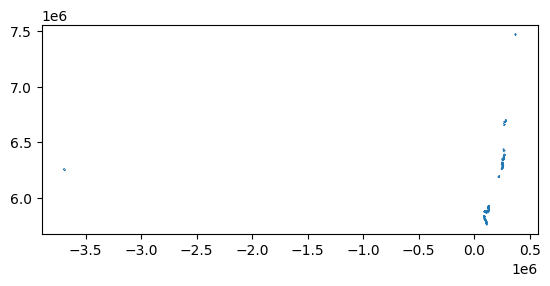

In [19]:
litoral=litoral.to_crs(32719)
litoral.plot()

La capa con la línea de playa contiene información para todo Chile, pero para efectos de este ejercicio sólo nos interesa la comuna de Viña del Mar. Por lo tanto, utilizamos la función `overlay` para crear un nuevo GeoDataFrame con la intersección de ambas capas:

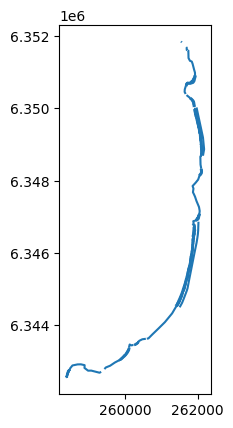

In [20]:
vina=vina.to_crs(32719)
cvm=litoral.overlay(vina)
cvm.plot();

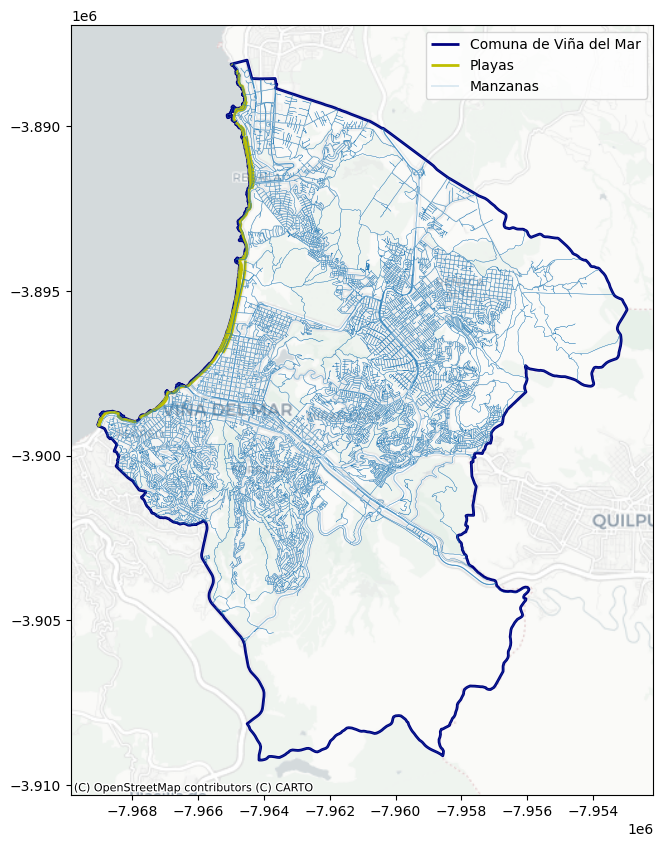

In [22]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

crs='3857' #usamos este SRC para graficar y agregar el mapa base con contextily

vina.to_crs(crs).boundary.plot(ax=ax,color='navy',lw=2,label='Comuna de Viña del Mar')
cvm.to_crs(crs).plot(ax=ax,color='y',lw=2,label='Playas')
#area.to_crs(crs).plot(ax=ax,color='y',alpha=0.5,label='Playas')
manz.to_crs(crs).boundary.plot(ax=ax,lw=0.2,label='Manzanas')
#manz_beach.to_crs(crs).boundary.plot(ax=ax,color='r',lw=0.2,label='Manzanas cerca playa')
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.legend()
plt.show()

### 3.5 ¿Qué manzanas se encuentran a menos de 500 m de la playa?

Creamos un buffer de 500m alrededor de la línea litoral:

<Axes: >

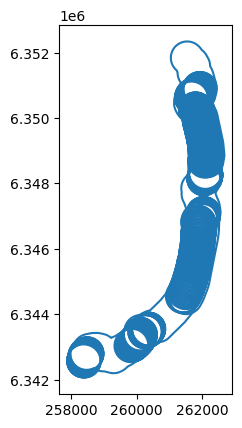

In [23]:
buf=cvm.buffer(500)
buf.boundary.plot()

Combinamos los buffers individuales en una única geometría usando `unary_union`, y usamos esta geometría para crear un nuevo GeoDataFrame:

In [24]:
buf

0      POLYGON ((259620.053 6343490.516, 259629.193 6...
1      POLYGON ((259525.343 6343431.397, 259534.897 6...
2      POLYGON ((259539.646 6343431.676, 259540.307 6...
3      POLYGON ((259375.306 6343181.042, 259396.397 6...
4      POLYGON ((260080.517 6342874.935, 260031.671 6...
                             ...                        
336    POLYGON ((261284.79 6350074.9, 261283.006 6350...
337    POLYGON ((262580.236 6348557.886, 262581.894 6...
338    POLYGON ((261377.465 6347734.959, 261376.624 6...
339    POLYGON ((260403.984 6342988.84, 260371.324 63...
340    POLYGON ((258685.697 6342347.554, 258665.321 6...
Length: 341, dtype: geometry

C:\Users\Erick\AppData\Local\Temp\ipykernel_28344\1494532128.py:1: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  area=gpd.GeoDataFrame([buf.unary_union], columns=['geometry'],crs=32719) # creamos un nuevo GeoDataframe


<Axes: >

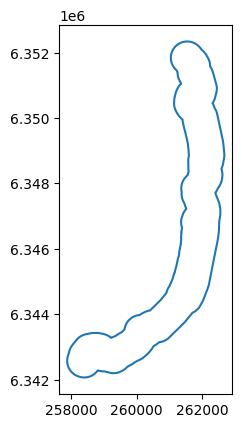

In [27]:
area=gpd.GeoDataFrame([buf.unary_union], columns=['geometry'],crs=32719) # creamos un nuevo GeoDataframe
area.boundary.plot()

In [28]:
area

,geometry
0,"POLYGON ((258205.575 6342101.92, 258202.443 63..."


In [29]:
manz_beach=manz.to_crs(32719).overlay(area)

<Axes: >

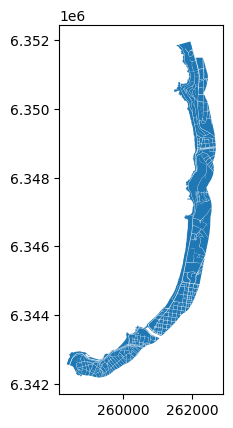

In [30]:
manz_beach.plot()

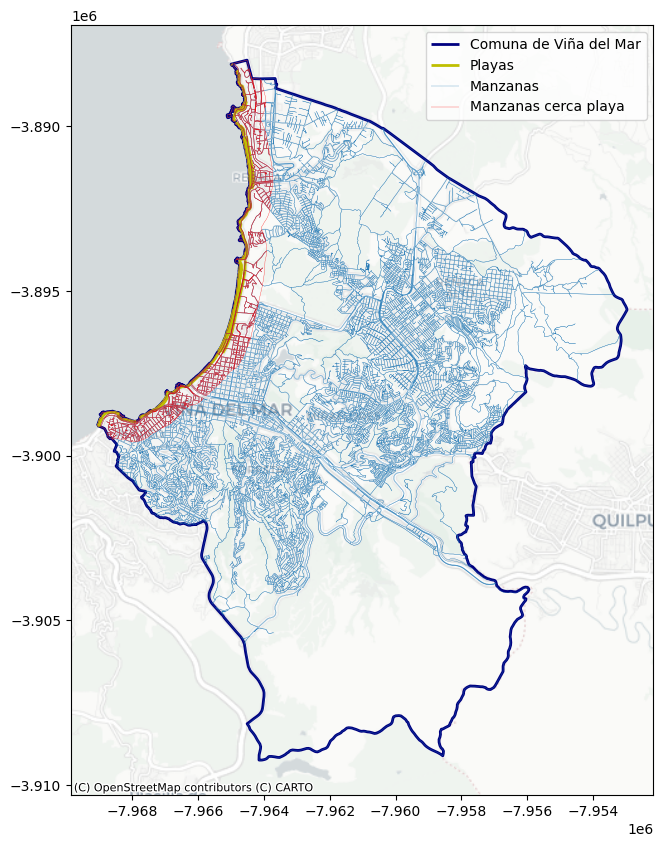

In [31]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

crs='3857' #usamos este SRC para graficar y agregar el mapa base con contextily

vina.to_crs(crs).boundary.plot(ax=ax,color='navy',lw=2,label='Comuna de Viña del Mar')
cvm.to_crs(crs).plot(ax=ax,color='y',lw=2,label='Playas')
manz.to_crs(crs).boundary.plot(ax=ax,lw=0.2,label='Manzanas')
manz_beach.to_crs(crs).boundary.plot(ax=ax,color='r',lw=0.2,label='Manzanas cerca playa')
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.legend();
plt.show()

### 3.6 ¿Cuánta población habita en zonas a 500 m de la línea litoral?

In [34]:
censo2017=gpd.read_file('vm_censo2017.gpkg').to_crs(32719)
display(censo2017.head())
censo2017.columns

,REGION,NOM_REGION,PROVINCIA,NOM_PROVIN,COMUNA,NOM_COMUNA,DISTRITO,LOC_ZON,ENT_MAN,CATEGORIA,...,TOTAL_VIVI,SHAPE_Leng_1,SHAPE_Area_1,CUT,N_REGION,N_PROVINCI,N_COMUNA,SHAPE_Leng_2,SHAPE_Area_2,geometry
0,5,REGIÓN DE VALPARAÍSO,51,VALPARAÍSO,5101,VALPARAÍSO,19,1,11,1,...,19,0.010676,3.081794e-06,5109,VALPARAÍSO,VALPARAÍSO,VIÑA DEL MAR,0.634746,0.011631,POINT (258625.042 6342310.458)
1,5,REGIÓN DE VALPARAÍSO,51,VALPARAÍSO,5101,VALPARAÍSO,19,7,16,1,...,47,0.005492,1.155222e-06,5109,VALPARAÍSO,VALPARAÍSO,VIÑA DEL MAR,0.634746,0.011631,POINT (258886.715 6341705.373)
2,5,REGIÓN DE VALPARAÍSO,51,VALPARAÍSO,5101,VALPARAÍSO,25,9,8,1,...,172,0.031189,6.825081e-06,5109,VALPARAÍSO,VALPARAÍSO,VIÑA DEL MAR,0.634746,0.011631,POINT (260367.487 6340191.662)
3,5,REGIÓN DE VALPARAÍSO,51,VALPARAÍSO,5101,VALPARAÍSO,25,9,29,1,...,10,0.003210,4.542561e-07,5109,VALPARAÍSO,VALPARAÍSO,VIÑA DEL MAR,0.634746,0.011631,POINT (261088.066 6340213.893)
4,5,REGIÓN DE VALPARAÍSO,51,VALPARAÍSO,5101,VALPARAÍSO,25,9,20,1,...,11,0.002480,3.114252e-07,5109,VALPARAÍSO,VALPARAÍSO,VIÑA DEL MAR,0.634746,0.011631,POINT (260780.426 6340117.089)


Index(['REGION', 'NOM_REGION', 'PROVINCIA', 'NOM_PROVIN', 'COMUNA',
       'NOM_COMUNA', 'DISTRITO', 'LOC_ZON', 'ENT_MAN', 'CATEGORIA',
       'NOM_CATEGO', 'MANZENT_I', 'TOTAL_PERS', 'TOTAL_VIVI', 'SHAPE_Leng_1',
       'SHAPE_Area_1', 'CUT', 'N_REGION', 'N_PROVINCI', 'N_COMUNA',
       'SHAPE_Leng_2', 'SHAPE_Area_2', 'geometry'],
      dtype='object')

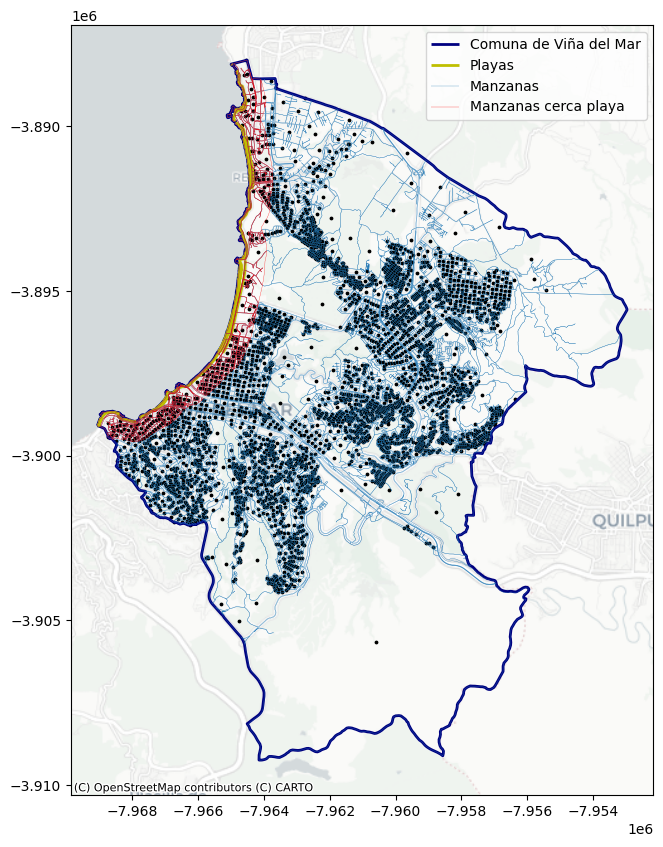

In [33]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

crs='3857' #usamos este SRC para graficar y agregar el mapa base con contextily

vina.to_crs(crs).boundary.plot(ax=ax,color='navy',lw=2,label='Comuna de Viña del Mar')
cvm.to_crs(crs).plot(ax=ax,color='y',lw=2,label='Playas')
manz.to_crs(crs).boundary.plot(ax=ax,lw=0.2,label='Manzanas')
manz_beach.to_crs(crs).boundary.plot(ax=ax,color='r',lw=0.2,label='Manzanas cerca playa')
censo2017.to_crs(crs).plot(ax=ax,markersize=3,color='k')
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.legend();
plt.show()

In [35]:
pob_costa=gpd.sjoin(manz_beach,censo2017[['TOTAL_PERS','geometry']],how='left')
pob_costa.head()

,CUT,N_REGION,N_PROVINCI,N_COMUNA,N_URBANO,MANZENT,COD_DISTRI,COD_ZONA,COD_MANZAN,VIV_COLECT,OTRO_USO,VIVIENDA,Mzent_TX,SHAPE_Leng,SHAPE_Area,geometry,index_right,TOTAL_PERS
0,5109,VALPARAÍSO,VALPARAÍSO,VIÑA DEL MAR,VIÑA DEL MAR,5.109041e+12,4,5,2,0,35,1028,5109041005002,0.029591,0.000017,"POLYGON ((262026.811 6351084.581, 262022.374 6...",10.0,168.0
1,5109,VALPARAÍSO,VALPARAÍSO,VIÑA DEL MAR,VIÑA DEL MAR,5.109041e+12,4,5,1,0,2,0,5109041005001,0.029230,0.000005,"POLYGON ((261909.845 6350809.866, 261899.84 63...",NaN,NaN
2,5109,VALPARAÍSO,VALPARAÍSO,VIÑA DEL MAR,VIÑA DEL MAR,5.109041e+12,4,5,5,0,6,209,5109041005005,0.005880,0.000002,"POLYGON ((262185.468 6350940.811, 262129.282 6...",15.0,289.0
3,5109,VALPARAÍSO,VALPARAÍSO,VIÑA DEL MAR,VIÑA DEL MAR,5.109041e+12,4,5,6,0,26,708,5109041005006,0.007865,0.000003,"POLYGON ((262058.429 6350783.313, 262036.551 6...",17.0,198.0
4,5109,VALPARAÍSO,VALPARAÍSO,VIÑA DEL MAR,VIÑA DEL MAR,5.109041e+12,4,5,7,0,27,542,5109041005007,0.006509,0.000003,"POLYGON ((262188.46 6350925.57, 262188.25 6350...",19.0,236.0


C:\Users\Erick\AppData\Local\Temp\ipykernel_28344\3782376198.py:12: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend();


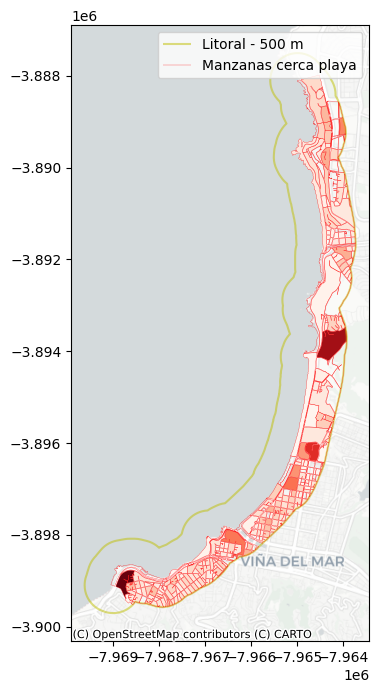

In [36]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

crs='3857'

#vina.to_crs(crs).boundary.plot(ax=ax,color='navy',lw=2,label='Comuna de Viña del Mar')
area.to_crs(crs).boundary.plot(ax=ax,color='y',alpha=0.5,label='Litoral - 500 m')
#manz.to_crs(crs).boundary.plot(ax=ax,lw=0.2,label='Manzanas')
manz_beach.to_crs(crs).boundary.plot(ax=ax,color='r',lw=0.2,label='Manzanas cerca playa')
pob_costa.to_crs(crs).plot(ax=ax,cmap='Reds',column='TOTAL_PERS',label='Población')
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.legend();
plt.show()

In [37]:
pob_costa.TOTAL_PERS.sum()

np.float64(29470.0)